In [1]:
import torch
import random
import pandas as pd
import torch_scatter
import torch.nn as nn
from tqdm import tqdm
import numpy as np
import time
import torch.optim as optim
import pandas as pd
import copy
import matplotlib.pyplot as plt

import os
import numpy as np
import torch
import functools
import json
from torch_geometric.data import Data
import enum

import sys
sys.path.append('../src')
from ice_graph.ice_graph import Ice_graph
from utils.graph_utils import compute_stats_batch,normalize_data,normalize,unnormalize
from models.MGN import MeshGraphNet
from models.GUnet import GUNet



In [2]:
#load graphs one by one
file_path = '../data_graphs/full_arctic_vel1h_survived'
#get file names sorted in order
graph_files = [i for i in os.listdir(file_path) if "list" not in i and "pt" in i]
graph_files = sorted(graph_files,key=lambda x:int(x.split("_")[-1].split(".")[0]) if x.split("_")[-1].split(".")[0].isdigit() else 0)
graph_list = []
for file in tqdm(graph_files):
    with open(os.path.join(file_path,file),'rb') as f:
            graph_list.append(torch.load(f))
            
graph_list[0], len(graph_list)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 279/279 [00:41<00:00,  6.66it/s]


(Data(x=[70777, 9], edge_index=[2, 416712], edge_attr=[416712, 3], y=[70777, 2], cells=[137522, 3], mesh_pos=[70777, 2], files=[3]),
 279)

In [3]:
class objectview(object):
    def __init__(self, d):
        self.__dict__ = d

for args in [
        {'model_type': 'meshgraphnet',
         'num_layers': 8,
         'batch_size': 8,
         'hidden_dim': 10,
         'epochs': 50,
         'opt': 'adam',
         'opt_scheduler': 'cos',
         'opt_restart': 0,
         'weight_decay': 5e-4,
         'lr': 0.001,
         'train_size': 40,
         'test_size': 2,
         'device':'cpu',
         'shuffle': True,
         'save_velo_val': False,
         'save_best_model': True,
         'checkpoint_dir': './best_models/',
         'postprocess_dir': './2d_loss_plots/'},
    ]:
        args = objectview(args)

#To ensure reproducibility the best we can, here we control the sources of
#randomness by seeding the various random number generators used in this Colab
#For more information, see: https://pytorch.org/docs/stable/notes/randomness.html
torch.manual_seed(5)  #Torch
random.seed(5)        #Python
np.random.seed(5)     #NumPy

In [5]:
!ls ../best_models2

crop_meshgraphnet_mse_plateau_nl6_bs4_hd6_ep50_wd0.005_lr0.0005_shuff_True_tr280_te40.csv
crop_meshgraphnet_mse_plateau_nl6_bs4_hd6_ep50_wd0.005_lr0.0005_shuff_True_tr280_te40.pt
crop_vel_gunet_mse_plateau_nl6_bs4_hd6_ep50_wd0.005_lr0.0005_shuff_True_tr280_te40.csv
crop_vel_gunet_mse_plateau_nl6_bs4_hd6_ep50_wd0.005_lr0.0005_shuff_True_tr280_te40.pt
crop_vel_meshgraphnet_mse_exp_nl6_bs4_hd6_ep50_wd0.005_lr0.0001_shuff_True_tr280_te40.csv
crop_vel_meshgraphnet_mse_exp_nl6_bs4_hd6_ep50_wd0.005_lr0.0001_shuff_True_tr280_te40.pt
crop_vel_meshgraphnet_mse_exp_nl6_bs4_hd6_ep50_wd0.005_lr0.0005_shuff_True_tr280_te40.csv
crop_vel_meshgraphnet_mse_exp_nl6_bs4_hd6_ep50_wd0.005_lr0.0005_shuff_True_tr280_te40.pt
crop_vel_meshgraphnet_mse_plateau_nl6_bs4_hd6_ep50_wd0.005_lr0.0005_shuff_True_tr280_te40.csv
crop_vel_meshgraphnet_mse_plateau_nl6_bs4_hd6_ep50_wd0.005_lr0.0005_shuff_True_tr280_te40.pt
edge_elements_vel_gunet_mse_plateau_nl10_bs4_hd8_ep80_wd0.005_lr0.00072_shuff_True_tr250_te30.csv
edge_

In [8]:
# load model.
dataset = graph_list
stats_list = compute_stats_batch(dataset)

model_name = "full_arctic_vel1h_survived_meshgraphnet_constrainet_loss_plateau_nl8_bs8_hd10_ep80_wd1e-05_lr0.00062_shuff_True_tr250_te20"
args.device = torch.device('cpu') # 
num_node_features = dataset[0].x.shape[1]
num_edge_features = dataset[0].edge_attr.shape[1]
num_classes = 2 # the dynamic variables have the shape of 2 (velocity)
PATH = f"../best_models2/{model_name}.pt"#os.path.join( checkpoint_dir, f'{model_name}.pt')

if args.model_type == 'meshgraphnet':
        model = MeshGraphNet(num_node_features, num_edge_features, args.hidden_dim, num_classes,
                            args)
if args.model_type == 'gunet':
    model = GUNet(num_node_features, num_classes)

model.load_state_dict(torch.load(PATH, map_location=args.device))

<All keys matched successfully>

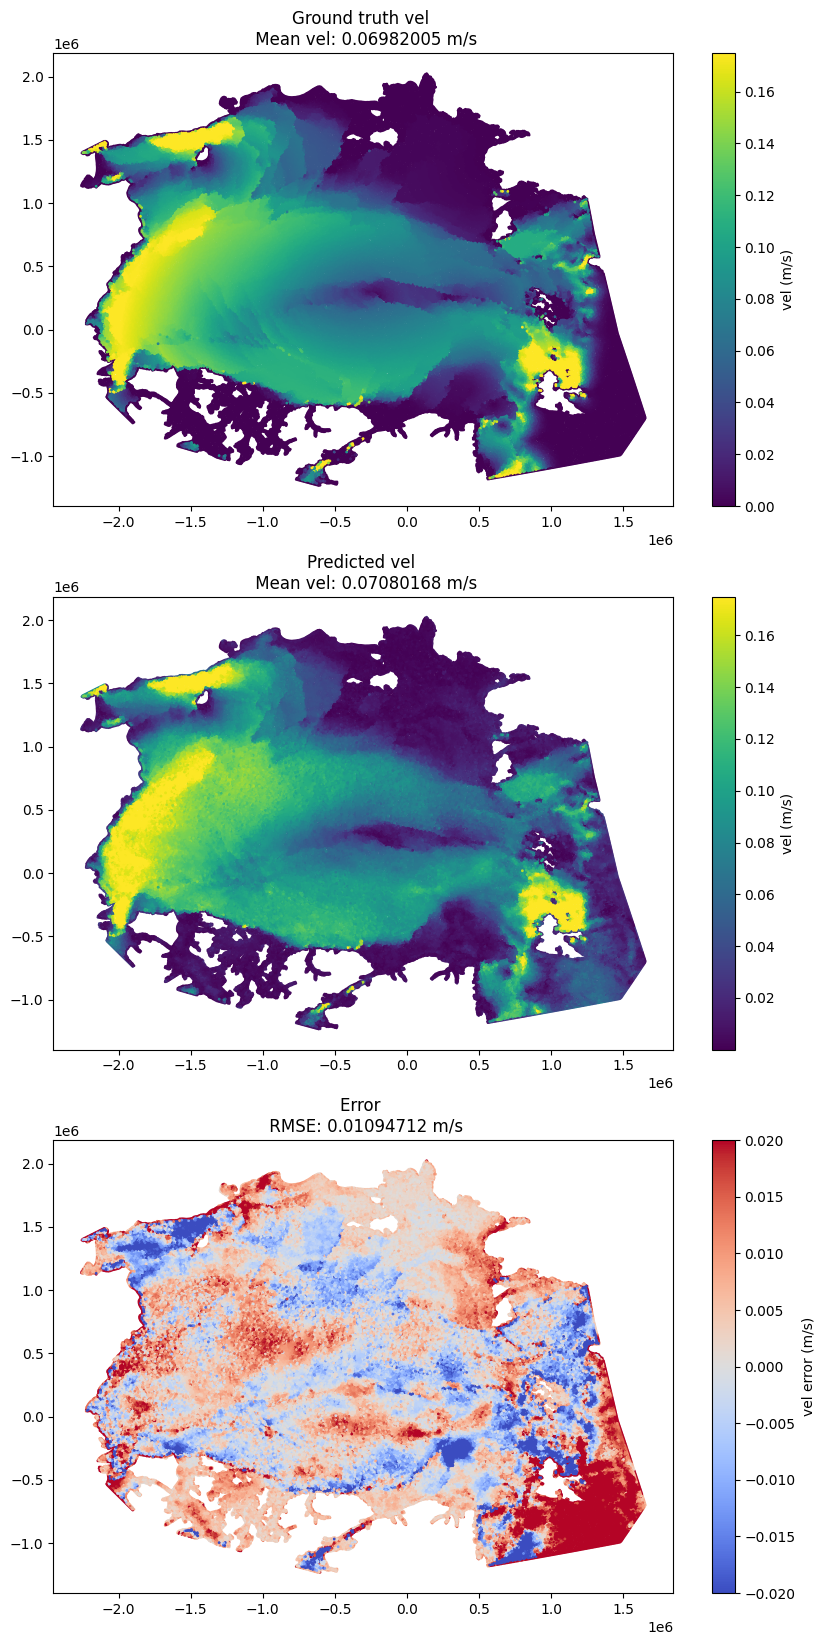

In [9]:
dataset_viz = copy.deepcopy(dataset[100:])
[mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge,mean_vec_y,std_vec_y] = stats_list


for i,graph in enumerate(dataset_viz):
    mask = graph.x[:, -1] == 0
    data = normalize_data(graph,mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge,mean_vec_y,std_vec_y)
    pred = model(data)

    pred = unnormalize(pred,mean_vec_y,std_vec_y).detach().numpy()

    target = unnormalize(data.y,mean_vec_y,std_vec_y)
    data.x = unnormalize(data.x,mean_vec_x,std_vec_x)

    ground = np.linalg.norm(target, axis=1)
    predicted = np.linalg.norm((pred), axis=1)

    error = predicted-ground
   

    rmse = np.sqrt(np.mean(error[mask]**2))
    fig, axs = plt.subplots(3,1,figsize=(10,20))
    vel_vmax = np.mean(ground) + 2*np.std(ground)


    im1 = axs[0].scatter(data.mesh_pos[:,0],data.mesh_pos[:,1],c=ground,s=1,vmax=vel_vmax)
    axs[0].set_title(f'Ground truth vel \n Mean vel: {np.mean(ground[mask]):.8f} m/s')
    plt.colorbar(im1,label='vel (m/s)')

    im2 = axs[1].scatter(data.mesh_pos[:,0],data.mesh_pos[:,1],c=predicted,s=1,vmax=vel_vmax)
    axs[1].set_title(f'Predicted vel \n Mean vel: {np.mean(predicted[mask]):.8f} m/s')
    plt.colorbar(im2,label='vel (m/s)')

    im3 = axs[2].scatter(data.mesh_pos[:,0],data.mesh_pos[:,1],c=error,s=1,vmin=-0.02,vmax=0.02,cmap='coolwarm')
    axs[2].set_title(f'Error \n RMSE: {rmse:.8f} m/s')
    plt.colorbar(im3,label='vel error (m/s)')
    break
    plt.savefig(f'../figures/rmse_vel/velpred_MGN_cropMGN_rmse_{i}.png')
    plt.close()

In [10]:
dataset_viz = copy.deepcopy(dataset)
[mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge,mean_vec_y,std_vec_y] = stats_list


rmse_inputs_pred = []
rmse_pred = []
rmse_inputs_true = []
kn_pred = []
kn_input = []
kn_true = []

predictions = []
targets  = []
inputs = []

for i,graph in tqdm(enumerate(dataset_viz)):
    mask = graph.x[:, -1] == 0
    data = normalize_data(graph,mean_vec_x,std_vec_x,mean_vec_edge,std_vec_edge,mean_vec_y,std_vec_y)
    pred = model(data)

    pred = unnormalize(pred,mean_vec_y,std_vec_y).detach().numpy()

    target = unnormalize(data.y,mean_vec_y,std_vec_y)
    data = unnormalize(data.x,mean_vec_x,std_vec_x)

    input_vel = np.linalg.norm(data[:,:2], axis=1)

    ground = np.linalg.norm(target, axis=1)
    predicted = np.linalg.norm(pred, axis=1)

    error_in_pred = input_vel - predicted
    error_in_true = input_vel - ground
    error = predicted-ground
    rmse = np.sqrt(np.mean(error[mask]**2))
    rmse_in_pred = np.sqrt(np.mean(error_in_pred[mask]**2))
    rmse_in_true = np.sqrt(np.mean(error_in_true[mask]**2))
    
    rmse_inputs_true.append(rmse_in_true)
    rmse_inputs_pred.append(rmse_in_pred)
    rmse_pred.append(rmse)

    kn_pred.append((predicted).mean())
    kn_input.append((input_vel).mean())
    kn_true.append((ground).mean())

    predictions.append(pred[mask])
    targets.append(target[mask])
    inputs.append(data[:,:2][mask])

279it [00:58,  4.78it/s]


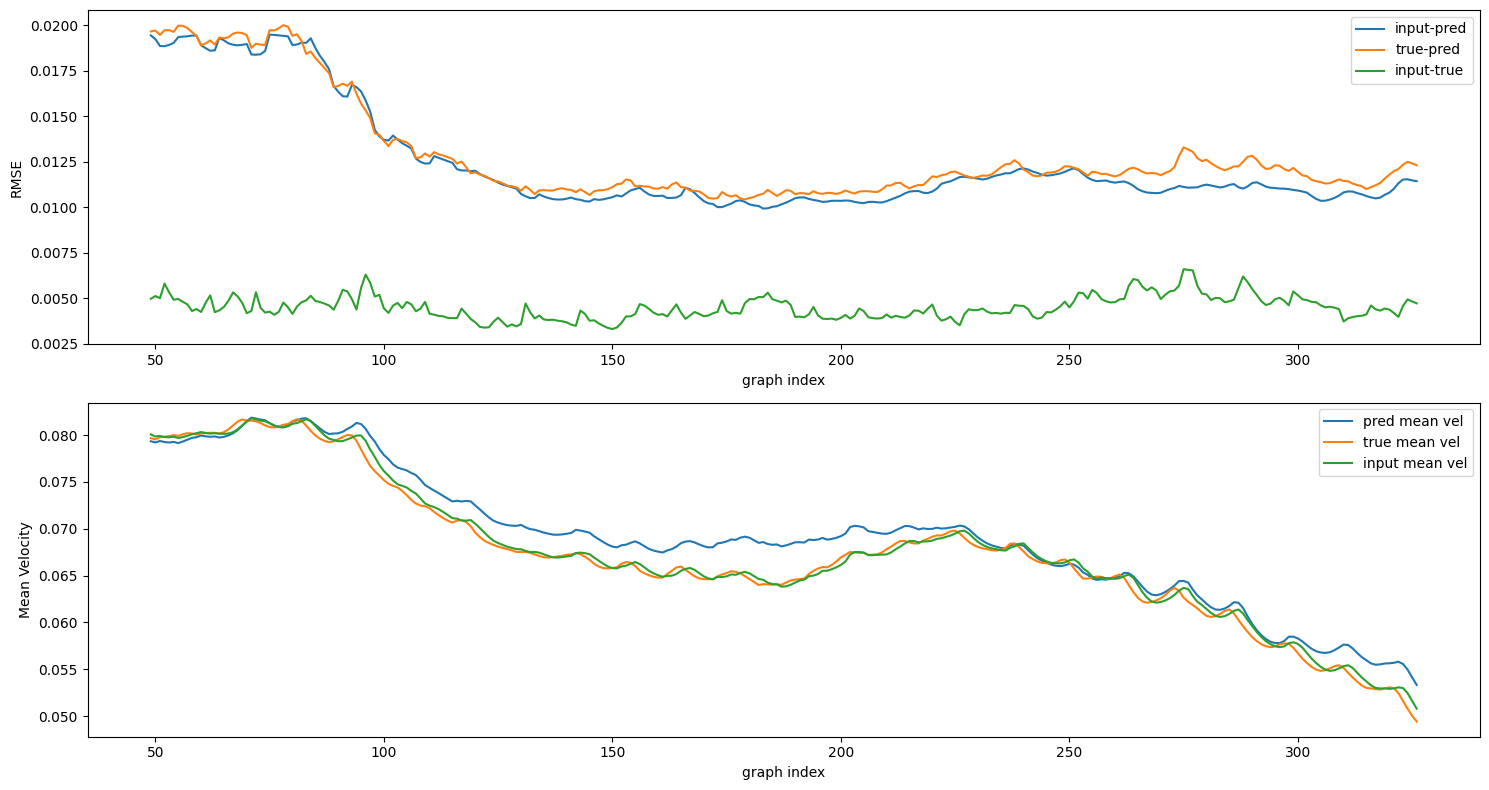

In [11]:
fig,axs = plt.subplots(2,1,figsize=(15,8))

x = np.arange(49,len(rmse_pred)+48)
axs[0].plot(x,rmse_inputs_pred[1:], label = "input-pred")
axs[0].plot(x,rmse_pred[1:], label = "true-pred")
axs[0].plot(x,rmse_inputs_true[1:], label = "input-true")
axs[0].set_xlabel("graph index")
axs[0].set_ylabel("RMSE")
#axs[0].set_ylim(0,0.02)
axs[0].legend()


axs[1].plot(x,kn_pred[1:], label = "pred mean vel")
axs[1].plot(x,kn_true[1:], label = "true mean vel")
axs[1].plot(x,kn_input[1:], label = "input mean vel")
axs[1].set_xlabel("graph index")
axs[1].set_ylabel("Mean Velocity")
axs[1].legend()
#axs[1].set_ylim(0,0.02)

plt.tight_layout()


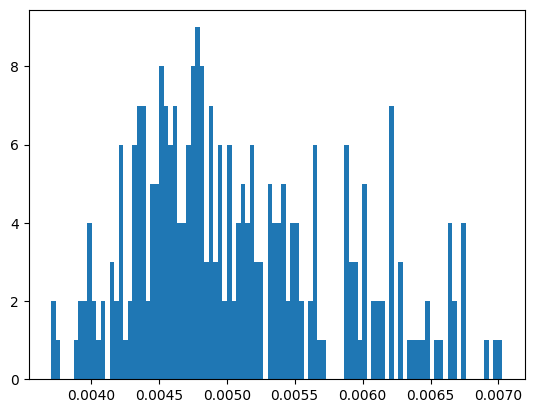

In [33]:
plt.hist(rmse_pred,bins=100)
pass

torch.Size([65367, 2])
(65367, 2)


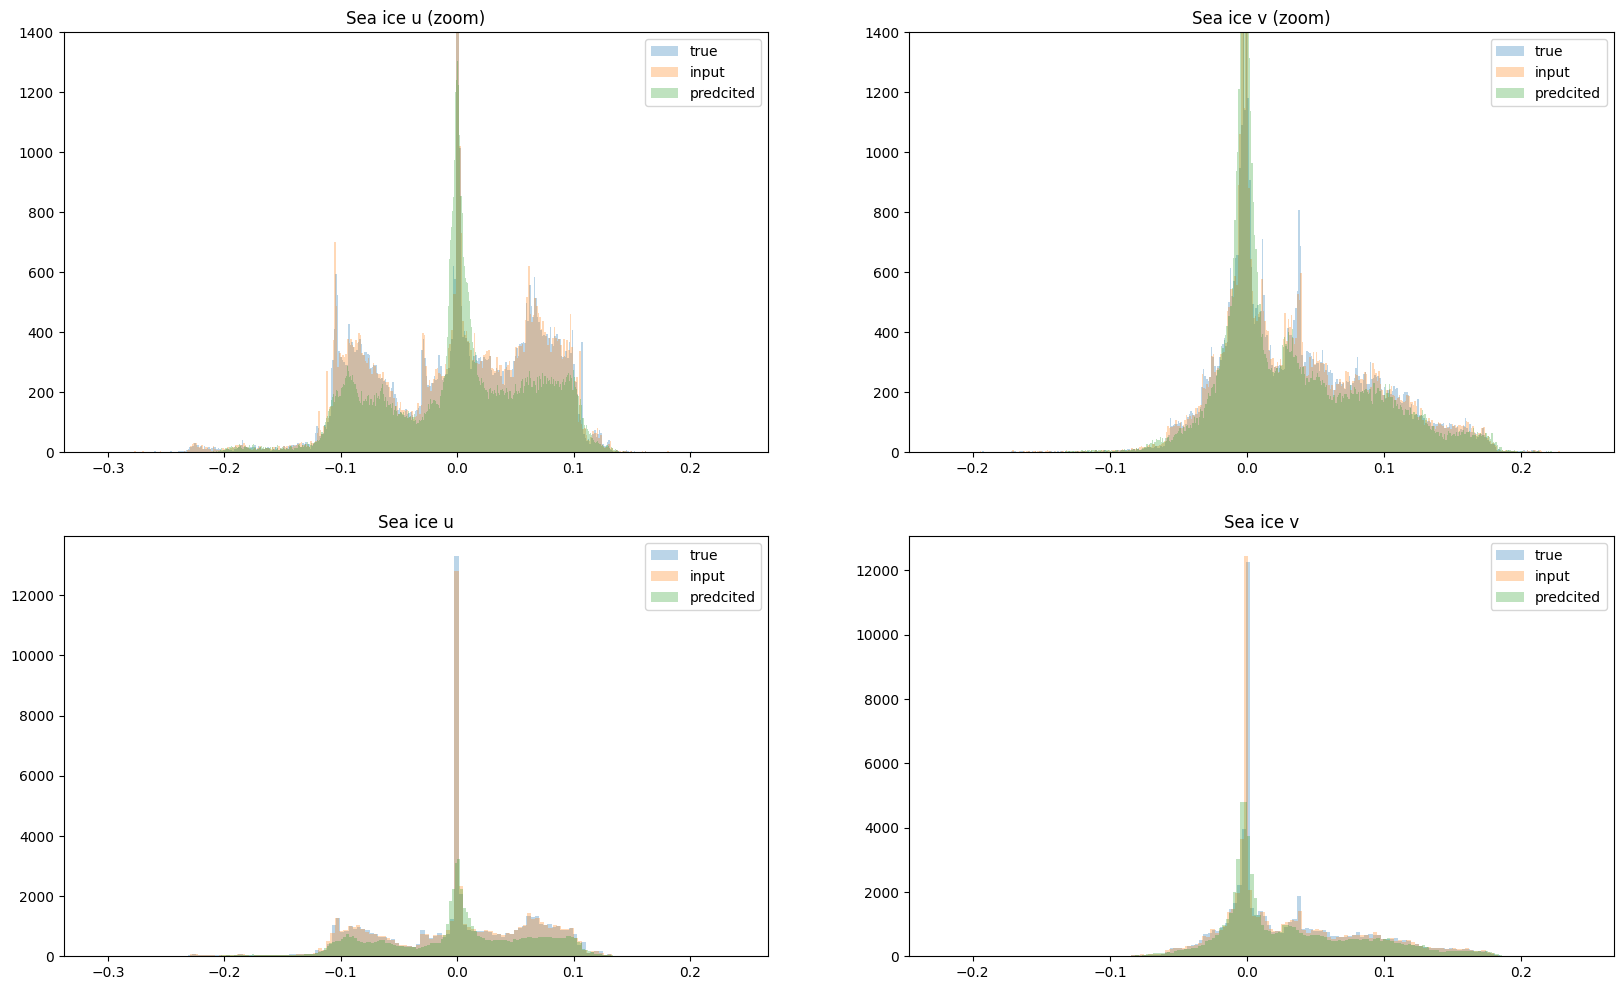

In [15]:
all_targets = targets[100]
all_predictions = predictions[100]
all_inputs = inputs[100]

print(all_targets.shape)
print(all_predictions.shape)
fig,axs = plt.subplots(2,2,figsize=(20,12))

axs[0,0].hist(all_targets[:,0],bins=400,alpha = 0.3, label = "true")
axs[0,0].hist(all_inputs[:,0],bins=400,alpha=0.3, label="input")
axs[0,0].hist(all_predictions[:,0],bins=400,alpha=0.3, label="predcited")


axs[0,0].set_ylim(0,1400)
axs[0,0].set_title("Sea ice u (zoom)")
axs[0,0].legend()


axs[0,1].hist(all_targets[:,1],bins=400,alpha = 0.3, label = "true")
axs[0,1].hist(all_inputs[:,1],bins=400,alpha=0.3, label="input")
axs[0,1].hist(all_predictions[:,1],bins=400,alpha=0.3, label="predcited")


axs[0,1].set_ylim(0,1400)
axs[0,1].set_title("Sea ice v (zoom)")
axs[0,1].legend()



axs[1,0].hist(all_targets[:,0],bins=150,alpha = 0.3, label = "true")
axs[1,0].hist(all_inputs[:,0],bins=150,alpha=0.3, label="input")
axs[1,0].hist(all_predictions[:,0],bins=150,alpha=0.3, label="predcited")


axs[1,0].set_title("Sea ice u")
axs[1,0].legend()


axs[1,1].hist(all_targets[:,1],bins=150,alpha = 0.3, label = "true")
axs[1,1].hist(all_inputs[:,1],bins=150,alpha=0.3, label="input")
axs[1,1].hist(all_predictions[:,1],bins=150,alpha=0.3, label="predcited")


axs[1,1].set_title("Sea ice v")
axs[1,1].legend()
